In [2]:
# %pip install numpy torch torchvision scikit-learn matplotlib pillow 
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image

c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)


2.4.0+cu118
11.8


In [4]:
import torch
print(torch.cuda.is_available())

True


In [22]:
# Define the custom dataset to load and preprocess images
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, base_dir, subfolders, transform=None):
        self.base_dir = base_dir
        self.subfolders = subfolders
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder)
            label = subfolder

            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(folder_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)
        
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

# Define the base directory and subfolders
base_dir = r'DIAT-uSAT_dataset'
subfolders = [
    r"3_long_blade_rotor", 
    r"3_short_blade_rotor", 
    r"Bird", 
    r"Bird+mini-helicopter", 
    r"drone", 
    r"rc_plane", 
]

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

In [6]:
# Load dataset
dataset = CustomImageDataset(base_dir, subfolders, transform=transform)

In [7]:
torch.manual_seed(42) 
indices = torch.randperm(len(dataset)) 
shuffled_dataset = torch.utils.data.Subset(dataset, indices)

In [8]:
train_size = int(0.85 * len(shuffled_dataset))
val_size = int(0.05 * len(shuffled_dataset))
test_size = len(shuffled_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(shuffled_dataset, [train_size, val_size, test_size])

In [9]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.5005665].


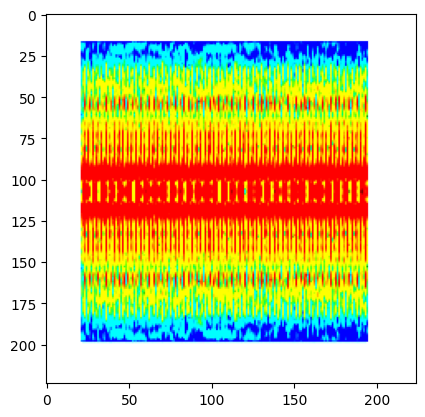

In [10]:
# Visualize one sample
sample_image, sample_label = next(iter(train_loader))
sample_image = sample_image[0] 
sample_image = sample_image.permute(1, 2, 0)  

plt.imshow(sample_image)
plt.show()

In [11]:
# Model definitions using VGG16 and VGG19
class CustomVGG(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomVGG, self).__init__()
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(base_model.classifier[0].in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Initialize models
vgg16_base = models.vgg16(pretrained=True)
for param in vgg16_base.parameters():
    param.requires_grad = False
model_vgg16 = CustomVGG(vgg16_base, num_classes=6)

vgg19_base = models.vgg19(pretrained=True)
for param in vgg19_base.parameters():
    param.requires_grad = False
model_vgg19 = CustomVGG(vgg19_base, num_classes=6)

c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1

In [12]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg16.to(device)
model_vgg19.to(device)

CustomVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_vgg16 = optim.Adam(model_vgg16.classifier.parameters(), lr=0.0001)
optimizer_vgg19 = optim.Adam(model_vgg19.classifier.parameters(), lr=0.0001)

In [15]:
# Learning rate scheduler
scheduler_vgg16 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg16, mode='min', factor=0.5, patience=2, min_lr=1e-7, verbose=True)
scheduler_vgg19 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg19, mode='min', factor=0.5, patience=2, min_lr=1e-7, verbose=True)

c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [16]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15):
    model.train()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * images.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
        
        scheduler.step(val_loss)
        
        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_model_{model.__class__.__name__}.pt")
        
        model.train()

In [17]:
# Train VGG16 model
train_model(model_vgg16, train_loader, val_loader, criterion, optimizer_vgg16, scheduler_vgg16)

Epoch [1/15], Loss: 0.4387, Accuracy: 0.8459
Validation Loss: 0.1879, Accuracy: 0.9215
Epoch [2/15], Loss: 0.1855, Accuracy: 0.9425
Validation Loss: 0.0998, Accuracy: 0.9793
Epoch [3/15], Loss: 0.1367, Accuracy: 0.9537
Validation Loss: 0.0645, Accuracy: 0.9917
Epoch [4/15], Loss: 0.1050, Accuracy: 0.9675
Validation Loss: 0.0616, Accuracy: 0.9793
Epoch [5/15], Loss: 0.0901, Accuracy: 0.9709
Validation Loss: 0.0399, Accuracy: 0.9959
Epoch [6/15], Loss: 0.0734, Accuracy: 0.9745
Validation Loss: 0.0526, Accuracy: 0.9917
Epoch [7/15], Loss: 0.0736, Accuracy: 0.9748
Validation Loss: 0.0418, Accuracy: 0.9876
Epoch [8/15], Loss: 0.0603, Accuracy: 0.9803
Validation Loss: 0.0782, Accuracy: 0.9752
Epoch [9/15], Loss: 0.0356, Accuracy: 0.9903
Validation Loss: 0.0259, Accuracy: 0.9959
Epoch [10/15], Loss: 0.0306, Accuracy: 0.9903
Validation Loss: 0.0311, Accuracy: 0.9876
Epoch [11/15], Loss: 0.0291, Accuracy: 0.9908
Validation Loss: 0.0225, Accuracy: 0.9959
Epoch [12/15], Loss: 0.0274, Accuracy: 0.

In [27]:
train_model(model_vgg19, train_loader, val_loader, criterion, optimizer_vgg19, scheduler_vgg19)

Epoch [1/15], Loss: 0.4951, Accuracy: 0.8272
Validation Loss: 0.1943, Accuracy: 0.9463
Epoch [2/15], Loss: 0.2381, Accuracy: 0.9214
Validation Loss: 0.1204, Accuracy: 0.9752
Epoch [3/15], Loss: 0.1827, Accuracy: 0.9388
Validation Loss: 0.0938, Accuracy: 0.9793
Epoch [4/15], Loss: 0.1547, Accuracy: 0.9486
Validation Loss: 0.0855, Accuracy: 0.9752
Epoch [5/15], Loss: 0.1305, Accuracy: 0.9570
Validation Loss: 0.0783, Accuracy: 0.9793
Epoch [6/15], Loss: 0.1150, Accuracy: 0.9629
Validation Loss: 0.0667, Accuracy: 0.9711
Epoch [7/15], Loss: 0.0914, Accuracy: 0.9699
Validation Loss: 0.0641, Accuracy: 0.9835
Epoch [8/15], Loss: 0.0948, Accuracy: 0.9687
Validation Loss: 0.1085, Accuracy: 0.9545
Epoch [9/15], Loss: 0.0790, Accuracy: 0.9728
Validation Loss: 0.0524, Accuracy: 0.9876
Epoch [10/15], Loss: 0.0799, Accuracy: 0.9721
Validation Loss: 0.0427, Accuracy: 0.9835
Epoch [11/15], Loss: 0.0642, Accuracy: 0.9789
Validation Loss: 0.0580, Accuracy: 0.9876
Epoch [12/15], Loss: 0.0600, Accuracy: 0.

In [24]:
def test_model(model, test_loader, criterion, label_encoder):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    test_acc = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for inference
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            test_acc += torch.sum(preds == labels.data).item()
            
            # Collect all predictions and labels for the classification report
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_acc / len(test_loader.dataset)

    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

    # Classification Report
    report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)
    print("Classification Report:")
    print(report)


In [26]:
label_encoder = dataset.label_encoder  # Extract the label encoder from your dataset
test_model(model_vgg16, test_loader, criterion, label_encoder)

Test Loss: 0.0371, Accuracy: 0.9877
Classification Report:
                      precision    recall  f1-score   support

  3_long_blade_rotor       0.97      0.99      0.98        72
 3_short_blade_rotor       0.97      0.98      0.97        85
                Bird       1.00      1.00      1.00        76
Bird+mini-helicopter       1.00      1.00      1.00        78
               drone       1.00      1.00      1.00        85
            rc_plane       0.99      0.97      0.98        90

            accuracy                           0.99       486
           macro avg       0.99      0.99      0.99       486
        weighted avg       0.99      0.99      0.99       486



In [31]:
test_model(model_vgg19, test_loader, criterion, label_encoder)

Test Loss: 0.0672, Accuracy: 0.9794
Classification Report:
                      precision    recall  f1-score   support

  3_long_blade_rotor       0.95      1.00      0.97        72
 3_short_blade_rotor       0.95      0.96      0.96        85
                Bird       1.00      1.00      1.00        76
Bird+mini-helicopter       0.99      0.97      0.98        78
               drone       1.00      1.00      1.00        85
            rc_plane       0.99      0.94      0.97        90

            accuracy                           0.98       486
           macro avg       0.98      0.98      0.98       486
        weighted avg       0.98      0.98      0.98       486



In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomCNN, self).__init__()
        # 1st Convolutional Block
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2nd Convolutional Block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3rd Convolutional Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 4th Convolutional Block
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, 6)  # Output for 6 classes

        # Dropout for Regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 1st Convolutional Block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        # 2nd Convolutional Block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # 3rd Convolutional Block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # 4th Convolutional Block
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        # Global Average Pooling
        x = self.global_avg_pool(x)
        
        # Flatten the output
        x = torch.flatten(x, 1)
        
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


In [33]:
# Initialize Deeper CNN model
model_deepercnn = CustomCNN(num_classes=6)
model_deepercnn.to(device)

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [34]:
# Loss and optimizer for Deeper CNN
optimizer_deepercnn = optim.Adam(model_deepercnn.parameters(), lr=0.0001)
scheduler_deepercnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_deepercnn, mode='min', factor=0.5, patience=2, min_lr=1e-7, verbose=True)

c:\Users\incha\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [35]:
# Train Deeper CNN model
train_model(model_deepercnn, train_loader, val_loader, criterion, optimizer_deepercnn, scheduler_deepercnn, num_epochs=20)

Epoch [1/20], Loss: 1.1738, Accuracy: 0.5967
Validation Loss: 0.6645, Accuracy: 0.7603
Epoch [2/20], Loss: 0.6537, Accuracy: 0.7758
Validation Loss: 0.4237, Accuracy: 0.8430
Epoch [3/20], Loss: 0.4995, Accuracy: 0.8275
Validation Loss: 0.3070, Accuracy: 0.8967
Epoch [4/20], Loss: 0.4246, Accuracy: 0.8593
Validation Loss: 0.2792, Accuracy: 0.9132
Epoch [5/20], Loss: 0.3655, Accuracy: 0.8779
Validation Loss: 0.2572, Accuracy: 0.9215
Epoch [6/20], Loss: 0.2984, Accuracy: 0.9008
Validation Loss: 0.1812, Accuracy: 0.9504
Epoch [7/20], Loss: 0.2787, Accuracy: 0.9068
Validation Loss: 0.1364, Accuracy: 0.9669
Epoch [8/20], Loss: 0.2473, Accuracy: 0.9192
Validation Loss: 0.1228, Accuracy: 0.9463
Epoch [9/20], Loss: 0.2156, Accuracy: 0.9321
Validation Loss: 0.0950, Accuracy: 0.9793
Epoch [10/20], Loss: 0.2060, Accuracy: 0.9342
Validation Loss: 0.1607, Accuracy: 0.9339
Epoch [11/20], Loss: 0.1893, Accuracy: 0.9376
Validation Loss: 0.0999, Accuracy: 0.9587
Epoch [12/20], Loss: 0.1726, Accuracy: 0.

In [36]:
# Test custom cnn
test_model(model_deepercnn, test_loader, criterion, label_encoder)

Test Loss: 0.0679, Accuracy: 0.9774
Classification Report:
                      precision    recall  f1-score   support

  3_long_blade_rotor       0.99      0.93      0.96        72
 3_short_blade_rotor       0.99      0.94      0.96        85
                Bird       1.00      1.00      1.00        76
Bird+mini-helicopter       1.00      0.99      0.99        78
               drone       1.00      1.00      1.00        85
            rc_plane       0.91      1.00      0.95        90

            accuracy                           0.98       486
           macro avg       0.98      0.98      0.98       486
        weighted avg       0.98      0.98      0.98       486



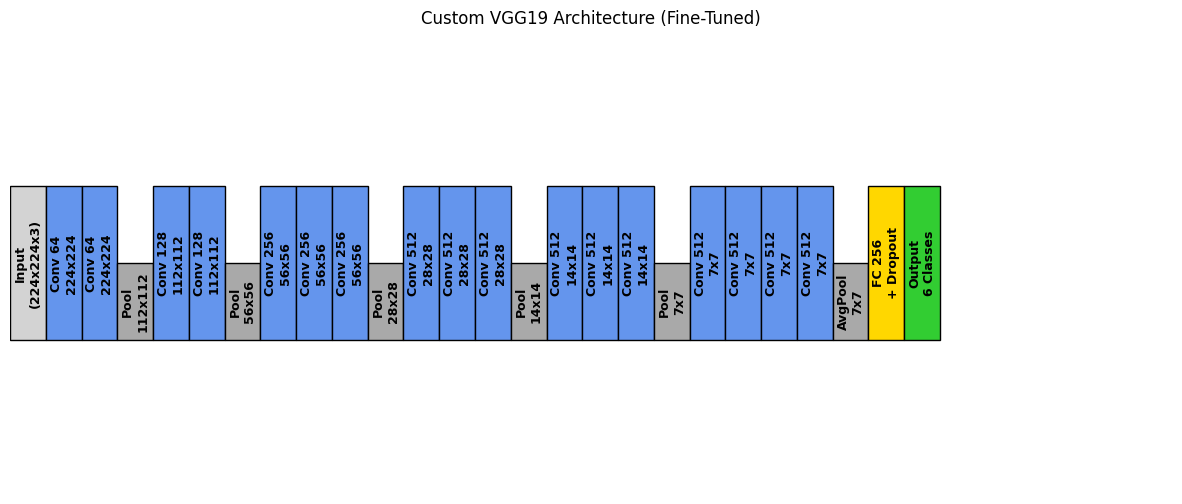

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


fig, ax = plt.subplots(figsize=(15, 6))


colors = {
    'input': '#d3d3d3',  # Light gray for Input Layer
    'conv': '#6495ed',   # Blue for Convolution + ReLU
    'pool': '#a9a9a9',   # Dark gray for Max Pooling
    'dense': '#ffd700',  # Gold for Fully Connected + ReLU
    'output': '#32cd32'  # Lime for Output (softmax)
}

def draw_block(ax, x, y, width, height, label, color):
    rect = patches.Rectangle((x, y), width, height, edgecolor='black', facecolor=color)
    ax.add_patch(rect)

    ax.text(x + width / 2, y + height / 2, label, color='black',
            ha='center', va='center', fontsize=9, weight="bold", rotation=90)

block_width = 0.4


draw_block(ax, 0, 1, block_width, 1, 'Input\n(224x224x3)', colors['input'])

# Conv + ReLU Layers
conv_layers = [
    ('Conv 64\n224x224', block_width), ('Conv 64\n224x224', block_width), ('Pool\n112x112', block_width),
    ('Conv 128\n112x112', block_width), ('Conv 128\n112x112', block_width), ('Pool\n56x56', block_width),
    ('Conv 256\n56x56', block_width), ('Conv 256\n56x56', block_width), ('Conv 256\n56x56', block_width), ('Pool\n28x28', block_width),
    ('Conv 512\n28x28', block_width), ('Conv 512\n28x28', block_width), ('Conv 512\n28x28', block_width), ('Pool\n14x14', block_width),
    ('Conv 512\n14x14', block_width), ('Conv 512\n14x14', block_width), ('Conv 512\n14x14', block_width), ('Pool\n7x7', block_width),
    ('Conv 512\n7x7', block_width), ('Conv 512\n7x7', block_width), ('Conv 512\n7x7', block_width), ('Conv 512\n7x7', block_width)  # Additional layers
]

x_offset = block_width
for layer, width in conv_layers:
    if 'Conv' in layer:
        draw_block(ax, x_offset, 1, width, 1, layer, colors['conv'])
    else:  
        draw_block(ax, x_offset, 1, width, 0.5, layer, colors['pool'])
    x_offset += width

# Adaptive Average Pooling
draw_block(ax, x_offset, 1, block_width, 0.5, 'AvgPool\n7x7', colors['pool'])
x_offset += block_width

# Fully Connected + Dropout + ReLU Layers
draw_block(ax, x_offset, 1, block_width, 1, 'FC 256\n+ Dropout', colors['dense'])
x_offset += block_width

# Output Layer
draw_block(ax, x_offset, 1, block_width, 1, 'Output\n6 Classes', colors['output'])


ax.set_xlim(0, x_offset + 3)
ax.set_ylim(0, 3)
ax.axis('off')


plt.title('Custom VGG19 Architecture (Fine-Tuned)')
plt.show()